In [2]:
from PIL import Image
from tqdm import tqdm
import numpy as np
from scipy import signal
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import imageio
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import glob
import os
from skimage import transform
from skimage.color import rgb2gray, gray2rgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

In [3]:
#Taken inspiration from Romachub. “Traffic Signs Recognition Test.” Kaggle, Kaggle, 6 Apr. 2020, www.kaggle.com/romachub/traffic-signs-recognition-test. 
def load_data(data_directory):
    file_names = [os.path.join(data_directory, f)
                      for f in os.listdir(data_directory)
                      if f.endswith(".png")]
    
    labels = []
    images = []
    
    for f in file_names:
            images.append(imageio.imread(f))
            labels.append(int(str(f[7:10])))
    return images, labels

In [4]:
# From CodePasta
def sobelDetect(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)

    sobel[sobel > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255
    return sobel

In [31]:
#Taken inspiration from ayushmankumar7Check out this Author's contributed articles., et al. “Perspective Transformation - Python OpenCV.” GeeksforGeeks, 9 July 2020, www.geeksforgeeks.org/perspective-transformation-python-opencv/. 
def useCVOnImages(images, image_size):
# model 2 (PCA + CV)
    imagesT = list()
    for img in tqdm(images):
        edgeImg = np.max( np.array([ sobelDetect(img[:,:, 0]), sobelDetect(img[:,:, 1]), sobelDetect(img[:,:, 2]) ]), axis=0 )
        # Coordinates that you want to Perspective Transform
        pts1 = np.float32([[0,0],[edgeImg.shape[1],0],[0,edgeImg.shape[0]],[edgeImg.shape[1],edgeImg.shape[0]]])
        # Size of the Transformed Image
        pts2 = np.float32([[0,0],[image_size,0],[0,image_size],[image_size,image_size]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(edgeImg,M,(image_size,image_size))
        rst = transform.resize(dst, (image_size, image_size))
        imagesT.append(rst)
    return imagesT

In [7]:
def train_model(images, labels, image_side_length):
    
    # partition images into categories
    imagesByCat = list()
    for i in range(len(np.unique(labels))):
        if pd.Series(labels).value_counts()[i] >= 100:
            image_list = list()
            for j in range(len(labels)):
                if labels[j] == i:
                    image_list.append(images[j])
            imagesByCat.append(np.array(image_list[0:100]).T)
    imagesByCat = np.asarray(imagesByCat)
                   
    #train model i.e. calculate principal axes
    allCatsEigvecs = np.zeros(imagesByCat.shape)
    category_means = np.zeros((23, image_side_length ** 2, 1))
    # find pca for category cat
    for cat in tqdm(range(len(imagesByCat))):
        num_images = imagesByCat[cat].shape[1]
        #print(num_images)
        data = imagesByCat[cat]
        #print(f"max for all images of cat {cat}")
        #print(data.shape)
        #print(np.max(data, axis=1).shape)
        #print(max(np.max(data, axis=1)))
        cat_mean_sign = np.mean(data, axis=1)
        #print(data[:,0])
        cat_mean_sign = np.reshape(cat_mean_sign, (-1, 1))
        #print(f"cat_mean_sign: \n {cat_mean_sign[cat_mean_sign > 30]}")
        category_means[cat] = cat_mean_sign
        #if cat == 1:
            #print(category_means[cat])
        mean_data = np.matlib.repmat(cat_mean_sign, 1, num_images)
        #print(mean_data.shape)
        Z = data - mean_data
        fake_cov = np.dot(Z.T, Z) / Z.shape[1]
        #print(fake_cov.shape)
        eigvals, V_fake = np.linalg.eig(fake_cov)
        V_real = np.dot(Z, V_fake)
        #print(f"V_real: \n{V_real}")
        #print(f"V_fake: \n{V_fake}")
        idx = eigvals.argsort()[::-1]   
        V_real_sorted = V_real[:,idx]
        #if len(V_real_sorted[:,0][V_real_sorted[:,0] > 2]) > 0:
            #print(V_real_sorted[:,0][V_real_sorted[:,0] > 2])
        #print(V_real_sorted.shape)

        allCatsEigvecs[cat] = V_real_sorted/np.linalg.norm(V_real_sorted)
                   
    return imagesByCat, category_means, allCatsEigvecs

In [8]:
def isClassificationCorrect(numEigsUsed, datapointInd, correctClass, category_means): # returns whether or not the image was classified correctly
    image = imagesByCat[correctClass, :, datapointInd].reshape(category_means[0].shape)
    #print("image to classify:");
    #plt.imshow(image.reshape((100,100)))
    #plt.pause(0.1) 
    #print(f"image shape: {image.shape}")
    numCats = allCatsEigvecs.shape[0]
    #print(f"allCatsEigvecs.shape: {allCatsEigvecs.shape}")
    #print(f"numCats: {numCats}")
    catScores = np.zeros(numCats) # catScores[3] = error for image with category 3 projection
    for cat in range(numCats):
        #print(f"category_means[cat].shape: {category_means[cat].shape}")
        z_image = image - category_means[cat]
        #print("zero-meaned image:")
        #plt.imshow(z_image.reshape((100,100)))
        #plt.pause(0.1) 
        #project and then reconstruct image
        projected_and_reduced = np.dot(allCatsEigvecs[cat, :, 0:numEigsUsed].T, z_image)
        reconst = np.dot(allCatsEigvecs[cat, :, 0:numEigsUsed], projected_and_reduced) + category_means[cat]
        #print("reconst image:")
        #plt.imshow(reconst.reshape((100,100)))
        #plt.pause(0.1)
        catScore = np.linalg.norm(image - reconst)
        #print(f"score for image on category {cat}: {catScore}")
        catScores[cat] = catScore
    #print(f"catScores: {catScores}")    
    predictedCat = np.argmin(catScores)
    #ghprint(f"argmin = {predictedCat}. Is this Correct? {predictedCat == correctClass}")
    return predictedCat == correctClass

In [9]:
def test_model(imagesByCat, allCatsEigvecs, category_means):
    num_categories = imagesByCat.shape[0]
    total_num_eigs = allCatsEigvecs.shape[2] # allCatsEigvecs
    num_datapoints = imagesByCat.shape[2]
    results = np.zeros((num_categories, total_num_eigs, num_datapoints))
    # num_categories = 23, num_eigs = 100, num_datapoints = 100
    for catInd in tqdm(np.arange(num_categories)):
        #print(f"checking category: {catInd}")
        for numEigsUsed in np.arange(total_num_eigs):
            #print(f"\tUsing {numEigsUsed} eigenvectors...")
            for datapointInd in (range(num_datapoints)):
                #print(f"\t\tClassifying image {datapointInd}...")
                results[catInd, numEigsUsed, datapointInd] = isClassificationCorrect(numEigsUsed, datapointInd, catInd, category_means) # images instead of master?
                
    return results

In [13]:
images, labels = load_data("images/")
image_side_length =30

# reshape cv'ed images
imagesT = useCVOnImages(images, image_side_length)
imagesT = [rgb2gray(image).flatten() for image in imagesT]

# reshape regualr images
images = [transform.resize(image, (image_side_length, image_side_length)) for image in images]
images = [rgb2gray(image).flatten() for image in images]

# train model
CV_imagesByCat, CV_category_means, CV_allCatsEigvecs = train_model(imagesT, labels, image_side_length)
imagesByCat, category_means, allCatsEigvecs = train_model(images, labels, image_side_length)

# test only PCA model
model1_data = test_model(imagesByCat, allCatsEigvecs, category_means)
model2_data = test_model(CV_imagesByCat, CV_allCatsEigvecs, CV_category_means)

/home/rraina/anaconda3/envs/emp/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
100%|██████████| 23/23 [28:27<00:00, 74.24s/it]


(100,)
[ 748. 1164. 1263. 1288. 1314. 1325. 1330. 1329. 1337. 1343. 1345. 1345.
 1345. 1345. 1345. 1346. 1346. 1346. 1347. 1351. 1351. 1351. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352. 1352.
 1352. 1352. 1352. 1352.]


Text(0, 0.5, 'Accuracy (% correct classifications)')

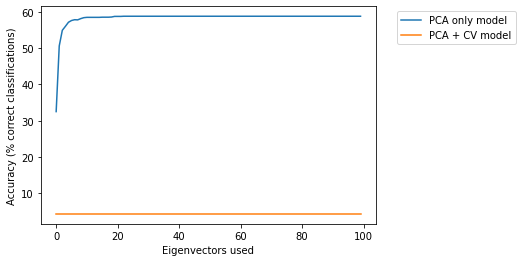

In [59]:
m1CorrectforEigsUsed = np.sum(model1_data, axis=(0,2))
m2CorrectforEigsUsed = np.sum(model2_data, axis=(0,2))
m1Accuracies = m1CorrectforEigsUsed / (model1_data.shape[0]*model1_data.shape[2])
m2Accuracies = m2CorrectforEigsUsed / (model2_data.shape[0]*model2_data.shape[2])
print(m1CorrectforEigsUsed.shape) # should be 100,1 or 100,
print(m1CorrectforEigsUsed)
plt.plot(np.arange(len(m1Accuracies)), m1Accuracies*100)
plt.plot(np.arange(len(m2Accuracies)), m2Accuracies*100)
plt.legend(['PCA only model', 'PCA + CV model'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Eigenvectors used')
plt.ylabel('Accuracy (% correct classifications)')

In [60]:
#0.2845 seconds of training time for model 1
#0.3372 seconds of eigenvec calc for model 2 + 13.82 seconds of cv processing time = 14.1572 secs
m1CorrectforEigsUsed = np.sum(model1_data, axis=(0,2))
m2CorrectforEigsUsed = np.sum(model2_data, axis=(0,2))
m1Accuracies = m1CorrectforEigsUsed / (model1_data.shape[0]*model1_data.shape[2])
m2Accuracies = m2CorrectforEigsUsed / (model2_data.shape[0]*model2_data.shape[2])
m1TrainingTime = 0.2845
m2TrainingTime = 14.1572
m1AccuracyPerTrainingTime = m1Accuracies/m1TrainingTime
m2AccuracyPerTrainingTime = m2Accuracies/m2TrainingTime
plt.plot(np.arange(len(m1AccuracyPerTrainingTime)), m1AccuracyPerTrainingTime)
plt.plot(np.arange(len(m2AccuracyPerTrainingTime)), m2AccuracyPerTrainingTime)
plt.legend(['PCA only model', 'PCA + CV model'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Eigenvectors used')
plt.ylabel('% Accuracy / Training Time (sec)')

Text(0, 0.5, '% Accuracy / Training Time (sec)')

In [26]:
model_difference_data = model1_data - model2_data
difByCat = np.sum(model_difference_data, axis=(1,2))
mostDifCat = np.argmax(difByCat)
mostSimCat = np.argmin(difByCat)
plt.bar(["Category " + str(mostDifCat), "Category " + str(mostSimCat)], [difByCat[mostDifCat], difByCat[mostSimCat]])
plt.ylabel('Net successful classification difference')

Text(0, 0.5, 'Net successful classification difference')

Text(0, 0.5, 'Training Time (sec)')

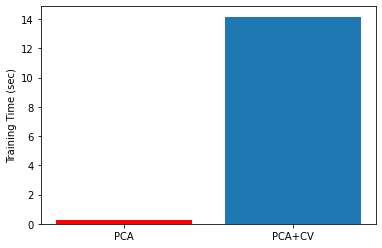

In [52]:
model_difference_data = model1_data - model2_data
difByCat = np.sum(model_difference_data, axis=(1,2))
mostDifCat = np.argmax(difByCat)
mostSimCat = np.argmin(difByCat)
m1TrainingTime = 0.2845
m2TrainingTime = 14.1572
y = plt.bar(["PCA", "PCA+CV"], [m1TrainingTime, m2TrainingTime])
y[0].set_color('r')
plt.ylabel('Training Time (sec)')

### References

1. Firoz, Munawwar. Background Removal with OpenCV (AKA Segmentation), www.codepasta.com/computer-vision/2016/11/06/background-segmentation-removal-with-opencv.html?fbclid=IwAR2TR4MUsXLTkV8g01U_LjJ55_kjm6fNHZQpBWDrtK8kfPBNvQn0HWEQaNw. 

2. Yemelyanov, Dmitry. “Chinese Traffic Signs.” Kaggle, 16 Apr. 2020, www.kaggle.com/dmitryyemelyanov/chinese-traffic-signs?select=images. 

3. COGS 118B HW4 Solutions

4. Romachub. “Traffic Signs Recognition Test.” Kaggle, Kaggle, 6 Apr. 2020, www.kaggle.com/romachub/traffic-signs-recognition-test. 

5. ayushmankumar7Check out this Author's contributed articles., et al. “Perspective Transformation - Python OpenCV.” GeeksforGeeks, 9 July 2020, www.geeksforgeeks.org/perspective-transformation-python-opencv/. 